In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

In [2]:
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')
#ladataset = pd.read_excel(r'../../data/raw/Local_government_finance_data_download.xlsx',sheet_name='Spending power totals')
#housing_net_supply_df = pd.read_excel('../../data/raw/Local-authority-housing-supply.xlsx', sheet_name='Net supply')
#housing_stock_df = pd.read_excel('../../data/raw/Local-authority-housing-supply.xlsx', sheet_name='Housing stock')
#population = pd.read_excel('../../data/raw/population_by_age.xlsx', sheet_name='Age bands')

In [3]:
# Section 114 notice dates by local authority (first relevant notice for each)
s114_dates = {
    'Nottingham': '2021-12-15',
    'Birmingham': '2023-09-05',
    'Woking': '2023-06-07',
    'Thurrock': '2022-12-18',
    'Croydon': '2020-11-11',
    'Slough': '2020-11-11',
    'North Northamptonshire': '2018-02-02',
    'West Northamptonshire': '2018-02-02',
}

# Convert to datetime
s114_dates = {k: pd.to_datetime(v) for k, v in s114_dates.items()}

# Map treatment date based on local authority
dataset['treatment_date'] = dataset['local_authority'].map(s114_dates)

# Create binary treatment indicator
dataset['treatment'] = dataset['treatment_date'].notna().astype(int)

In [4]:
dataset.columns

Index(['registered_charity_number', 'charity_name', 'postcode',
       'charity_status', 'charity_type', 'date_of_registration',
       'date_of_removal', 'latest_income', 'charity_activities',
       'charity_has_land', 'companyNumber', 'local_authority', 'size_category',
       'classification_description', 'registration_year', 'removal_year',
       'registration_month', 'removal_month', 'registration_fy', 'removal_fy',
       'Children_Youth', 'Economic_Social_Development', 'Education_Research',
       'Environment_Animals', 'Grants_Related', 'Health_Disability',
       'Housing_Infrastructure', 'Human_Rights_Advocacy',
       'Other_Miscellaneous', 'Overseas_Famine_Relief', 'Religion_Faith',
       'treatment_date', 'treatment'],
      dtype='object')

In [5]:
# Ensure date columns are datetime
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'])
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'])

# Define FY end date mapping
# Get financial years from 2010 to 2025
fy_end_dates = (
    dataset['removal_fy']
    .dropna()
    .astype(int)
)
fy_end_dates = sorted(fy_end_dates[(fy_end_dates >= 2014) & (fy_end_dates <= 2025)].unique())

fy_end_date_map = {fy: pd.Timestamp(f"{int(fy)+1}-03-31") for fy in fy_end_dates}

# Compute number of active charities at end of each FY by council
active_by_fy_la = {}

for fy, end_date in fy_end_date_map.items():
    previous_end_date = end_date - pd.DateOffset(years=1)
    active_mask = (
        (dataset['date_of_registration'] <= previous_end_date) &
        (
            dataset['date_of_removal'].isna() |
            (dataset['date_of_removal'] > previous_end_date)
        )
    )
    active_count = (
        dataset[active_mask]
        .groupby('local_authority')
        .size()
        .rename(fy)
    )
    active_by_fy_la[fy] = active_count

active_by_fy_la_df = pd.DataFrame(active_by_fy_la).fillna(0).astype(int)

# Your original: removals by FY and local authority
removed_by_fy_la = (
    dataset
    .groupby(['local_authority', 'removal_fy'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# Align indices
active_by_fy_la_df = active_by_fy_la_df.reindex(removed_by_fy_la.index)

# Calculate removal rate per FY
removal_rate_by_fy_la = removed_by_fy_la / active_by_fy_la_df
removal_rate_by_fy_la

removal_fy,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0
local_authority,,,,,,,,,,,,
Aberdeen City,0.000000,0.000000,0.181818,0.100000,0.100000,0.000000,0.000000,0.111111,0.000000,0.000000,0.375000,0.000000
Aberdeenshire,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Adur,0.000000,0.016393,0.040323,0.032787,0.032258,0.024390,0.016000,0.038462,0.030534,0.015152,0.015038,0.000000
Amber Valley,0.006536,0.031847,0.022152,0.024922,0.037267,0.035144,0.022436,0.032258,0.006472,0.019169,0.025723,0.000000
Angus,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
Wrexham,0.010791,0.035088,0.027778,0.044983,0.013746,0.036066,0.029126,0.047619,0.022436,0.028481,0.049536,0.000000
Wychavon,0.004274,0.020921,0.024641,0.012170,0.028340,0.028689,0.032389,0.024390,0.020704,0.029412,0.031915,0.002151
Wyre,0.016327,0.032653,0.036585,0.049383,0.029536,0.038627,0.004425,0.039130,0.043478,0.022422,0.026786,0.004484


In [6]:
# Step 1: Wide to long
panel_df = removal_rate_by_fy_la.reset_index().melt(
    id_vars='local_authority',
    var_name='financial_year',
    value_name='removed_rate'
)

# Step 2: Add treatment info
# Map treatment and treatment_date from the original dataset
treatment_map = dataset.groupby('local_authority')[['treatment', 'treatment_date']].first()
panel_df = panel_df.merge(treatment_map, on='local_authority', how='left')

# Step 3: Compute 'post' indicator
panel_df['financial_year'] = panel_df['financial_year'].astype(int)
panel_df['treatment_year'] = panel_df['treatment_date'].dt.year
panel_df['post'] = (panel_df['financial_year'] >= panel_df['treatment_year']).astype(int)
panel_df.loc[panel_df['treatment'].isna(), 'post'] = 0  # ensure untreated are always 0

classification_vars = [
    'Children_Youth', 'Economic_Social_Development', 'Education_Research',
    'Environment_Animals', 'Grants_Related', 'Health_Disability',
    'Housing_Infrastructure', 'Human_Rights_Advocacy',
    'Other_Miscellaneous', 'Overseas_Famine_Relief', 'Religion_Faith'
]
classification_map = dataset.groupby('local_authority')[classification_vars].max()
panel_df = panel_df.merge(classification_map, on='local_authority', how='left')


In [7]:
formula = (
    'removed_rate ~ post + treatment + treatment:post + '
    'C(local_authority) + C(financial_year) + ' +
    ' + '.join(classification_vars)
)

model = smf.ols(formula, data=panel_df).fit(
    cov_type='cluster', cov_kwds={'groups': panel_df['local_authority']}
)
summary = model.summary()
summary

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 374, but rank is 12
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           removed_rate   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     214.2
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          8.33e-153
Time:                        15:01:10   Log-Likelihood:                 9406.1
No. Observations:                4200   AIC:                        -1.809e+04
Df Residuals:                    3838   BIC:                        -1.579e+04
Df Model:                         361                                         
Covariance Type:              cluster                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.0174      0.000     48.141      0.000       0.017       0.018
C(local_authority)[T.Aberdeenshire]                           -0.0009   6.07e-05    -15.567      0.000      -0.001      -0.001
C(local_authority)[T.Adur]                                    -0.0017   3.27e-06   -530.345      0.000      -0.002      -0.002
C(local_authority)[T.Amber Valley]                            -0.0015   3.27e-06   -464.338      0.000      -0.002      -0.002
C(local_authority)[T.Angus]                                   -0.0146   9.24e-06  -1583.340      0.000      -0.015      -0.015
C(local_authority)[T.Argyll and Bute]                         -0.0197   4.95e-06  -3989.002      0.000      -0.020      -0.020
C(local_authority)[T.Armagh City, Banbridge and Craigavon]    -0.0126   1.25e-05  -1013.722      0.000      -0.013      -0.013
C(local_authority)[T.Arun]                                     0.0031   3.27e-06    962.896      0.000       0.003       0.003
C(local_authority)[T.Ashfield]                                 0.0061   3.27e-06   1875.302      0.000       0.006       0.006
C(local_authority)[T.Ashford]                                 -0.0012   3.27e-06   -379.951      0.000      -0.001      -0.001
C(local_authority)[T.Babergh]                                 -0.0035   3.27e-06  -1080.507      0.000      -0.004      -0.004
C(local_authority)[T.Barking and Dagenham]                    -0.0012   3.27e-06   -374.043      0.000      -0.001      -0.001
C(local_authority)[T.Barnet]                                  -0.0048   3.27e-06  -1452.572      0.000      -0.005      -0.005
C(local_authority)[T.Barnsley]                                 0.0038   3.27e-06   1163.996      0.000       0.004       0.004
C(local_authority)[T.Basildon]                             -4.329e-05   3.27e-06    -13.233      0.000   -4.97e-05   -3.69e-05
C(local_authority)[T.Basingstoke and Deane]                    0.0009   3.27e-06    271.733      0.000       0.001       0.001
C(local_authority)[T.Bassetlaw]                               -0.0045   3.27e-06  -1381.166      0.000      -0.005      -0.005
C(local_authority)[T.Bath and North East Somerset]            -0.0034   3.27e-06  -1048.800      0.000      -0.003      -0.003
C(local_authority)[T.Bedford]                                  0.0029   3.27e-06    879.932      0.000       0.003       0.003
C(local_authority)[T.Belfast]                                  0.0015   1.06e-05    139.810      0.000       0.001       0.002
C(local_authority)[T.Bexley]                                  -0.0035   3.27e-06  -1059.990      0.000      -0.003      -0.003
C(local_authority)[T.Birmingham]   

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# --- Assumes dataset is already loaded and 'dataset' is your DataFrame ---

# Ensure date columns are datetime
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'])
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'])

# --- Step 1: Create Financial Year End Dates ---
fy_end_dates = (
    dataset['removal_fy'].dropna().astype(int)
)
fy_end_dates = sorted(fy_end_dates[(fy_end_dates >= 2014) & (fy_end_dates <= 2025)].unique())
fy_end_date_map = {fy: pd.Timestamp(f"{int(fy)+1}-03-31") for fy in fy_end_dates}

# --- Step 2: Calculate Active Charities at Each FY End ---
active_by_fy_la = {}
for fy, end_date in fy_end_date_map.items():
    prev_end_date = end_date - pd.DateOffset(years=1)
    active_mask = (
        (dataset['date_of_registration'] <= prev_end_date) &
        (dataset['date_of_removal'].isna() | (dataset['date_of_removal'] > prev_end_date))
    )
    active_count = dataset[active_mask].groupby('local_authority').size().rename(fy)
    active_by_fy_la[fy] = active_count

active_by_fy_la_df = pd.DataFrame(active_by_fy_la).fillna(0).astype(int)

# --- Step 3: Calculate Removals by FY ---
removed_by_fy_la = (
    dataset
    .groupby(['local_authority', 'removal_fy'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# Align indices
active_by_fy_la_df = active_by_fy_la_df.reindex(removed_by_fy_la.index)
removal_rate_by_fy_la = removed_by_fy_la / active_by_fy_la_df

# --- Step 4: Convert to Long Format Panel ---
panel_df = removal_rate_by_fy_la.reset_index().melt(
    id_vars='local_authority',
    var_name='financial_year',
    value_name='removed_rate'
)

# --- Step 5: Merge Treatment Info ---
treatment_map = dataset.groupby('local_authority')[['treatment', 'treatment_date']].first()
panel_df = panel_df.merge(treatment_map, on='local_authority', how='left')

panel_df['financial_year'] = panel_df['financial_year'].astype(int)
panel_df['treatment_year'] = panel_df['treatment_date'].dt.year
panel_df['event_time'] = panel_df['financial_year'] - panel_df['treatment_year']

# Create event study dummies with safe names
for i in range(-5, 6):
    if i != -1:  # omit -1 as base
        col_name = f"event_m{abs(i)}" if i < 0 else f"event_{i}"
        panel_df[col_name] = (panel_df['event_time'] == i).astype(int)

# --- Step 6: Add lag of outcome variable ---
panel_df = panel_df.sort_values(['local_authority', 'financial_year'])
panel_df['removed_rate_lag1'] = panel_df.groupby('local_authority')['removed_rate'].shift(1)

# --- Step 7: Add classification controls ---
classification_vars = [
    'Children_Youth', 'Economic_Social_Development', 'Education_Research',
    'Environment_Animals', 'Grants_Related', 'Health_Disability',
    'Housing_Infrastructure', 'Human_Rights_Advocacy',
    'Other_Miscellaneous', 'Overseas_Famine_Relief', 'Religion_Faith'
]
classification_map = dataset.groupby('local_authority')[classification_vars].max()
panel_df = panel_df.merge(classification_map, on='local_authority', how='left')

# --- Step 8: Pre-trend interaction (optional) ---
panel_df['pretrend'] = panel_df['financial_year'] - panel_df['financial_year'].min()
panel_df['pretrend_treat'] = panel_df['pretrend'] * panel_df['treatment']
panel_df_model = panel_df.dropna(subset=['removed_rate', 'removed_rate_lag1'])

# --- Step 9: Build formula ---
event_terms = [f'event_m{abs(i)}' if i < 0 else f'event_{i}' for i in range(-5, 6) if i != -1]

formula = (
    'removed_rate ~ removed_rate_lag1 + pretrend_treat + ' +
    ' + '.join(event_terms) +
    ' + C(local_authority) + C(financial_year) + ' +
    ' + '.join(classification_vars)
)
# --- Step 10: Fit OLS with clustered standard errors ---
model = smf.ols(formula=formula, data=panel_df_model).fit(
    cov_type='cluster', cov_kwds={'groups': panel_df_model['local_authority']}
)
model.summary()

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 382, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           removed_rate   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     118.1
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          2.72e-136
Time:                        15:01:11   Log-Likelihood:                 8498.8
No. Observations:                3850   AIC:                        -1.625e+04
Df Residuals:                    3478   BIC:                        -1.393e+04
Df Model:                         371                                         
Covariance Type:              cluster                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.0343      0.002     21.068      0.000       0.031       0.037
C(local_authority)[T.Aberdeenshire]                            0.0017      0.000      6.792      0.000       0.001       0.002
C(local_authority)[T.Adur]                                    -0.0011   9.94e-05    -11.495      0.000      -0.001      -0.001
C(local_authority)[T.Amber Valley]                            -0.0015   9.18e-05    -16.115      0.000      -0.002      -0.001
C(local_authority)[T.Angus]                                   -0.0173      0.001    -25.421      0.000      -0.019      -0.016
C(local_authority)[T.Argyll and Bute]                         -0.0232      0.001    -25.112      0.000      -0.025      -0.021
C(local_authority)[T.Armagh City, Banbridge and Craigavon]    -0.0155      0.001    -26.374      0.000      -0.017      -0.014
C(local_authority)[T.Arun]                                     0.0037      0.000     22.348      0.000       0.003       0.004
C(local_authority)[T.Ashfield]                                 0.0058      0.000     21.375      0.000       0.005       0.006
C(local_authority)[T.Ashford]                                 -0.0010      0.000    -10.143      0.000      -0.001      -0.001
C(local_authority)[T.Babergh]                                 -0.0042      0.000    -21.846      0.000      -0.005      -0.004
C(local_authority)[T.Barking and Dagenham]                    -0.0028   8.78e-05    -31.671      0.000      -0.003      -0.003
C(local_authority)[T.Barnet]                                  -0.0056      0.000    -24.248      0.000      -0.006      -0.005
C(local_authority)[T.Barnsley]                                 0.0046      0.000     25.371      0.000       0.004       0.005
C(local_authority)[T.Basildon]                             -9.046e-05   6.29e-05     -1.439      0.150      -0.000    3.28e-05
C(local_authority)[T.Basingstoke and Deane]                    0.0014   6.46e-05     21.393      0.000       0.001       0.002
C(local_authority)[T.Bassetlaw]                               -0.0048      0.000    -20.974      0.000      -0.005      -0.004
C(local_authority)[T.Bath and North East Somerset]            -0.0048      0.000    -26.385      0.000      -0.005      -0.004
C(local_authority)[T.Bedford]                                  0.0038      0.000     30.140      0.000       0.004       0.004
C(local_authority)[T.Belfast]                                  0.0025   7.91e-05     31.284      0.000       0.002       0.003
C(local_authority)[T.Bexley]                                  -0.0047      0.000    -24.236      0.000      -0.005      -0.004
C(local_authority)[T.Birmingham]   

In [ ]:
'''
ADF: remove Non-stationary series (local councils)
'''
from statsmodels.tsa.stattools import adfuller

results = {}
for la in panel_df['local_authority'].unique():
    series = panel_df.loc[panel_df['local_authority'] == la, 'removed_rate'].dropna()
    if len(series) > 10:  # require enough data points
        result = adfuller(series)
        results[la] = {'ADF Statistic': result[0], 'p-value': result[1]}
        
for la, res in results.items():
    print(f"Local Authority: {la}, ADF Stat: {res['ADF Statistic']:.4f}, p-value: {res['p-value']:.4f}")

import pandas as pd

# Assuming your dictionary is stored in variable `results`
# Flatten the dictionary into a list of rows for DataFrame construction
rows = []
for la, stats in results.items():
    rows.append({
        'local_authority': la,
        'adf_stat': stats['ADF Statistic'],
        'p_value': stats['p-value']
    })

df_adf = pd.DataFrame(rows)

# Define thresholds for problematic series
threshold_adf_stat = 1e10

problematic = df_adf[
    (df_adf['p_value'] == 0) |
    (df_adf['p_value'] == 1) |
    (df_adf['adf_stat'].abs() > threshold_adf_stat)
]

print("Problematic Local Authorities:")
print(problematic['local_authority'].tolist())

# Optional: Filter them out from your panel_df if you want clean data
clean_panel_df = panel_df[~panel_df['local_authority'].isin(problematic['local_authority'])]

print(f"Clean panel data now has {clean_panel_df['local_authority'].nunique()} local authorities.")

# Keep only stationary series (p-value < 0.05)
stationary = df_adf[df_adf['p_value'] < 0.05]

# Filter panel data accordingly
stationary_panel_df = panel_df[panel_df['local_authority'].isin(stationary['local_authority'])]

print(f"Panel data now contains {stationary_panel_df['local_authority'].nunique()} stationary local authorities.")


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\

Local Authority: Aberdeen City, ADF Stat: -2.7939, p-value: 0.0591
Local Authority: Aberdeenshire, ADF Stat: -3.3166, p-value: 0.0142
Local Authority: Adur, ADF Stat: 1.3460, p-value: 0.9969
Local Authority: Amber Valley, ADF Stat: -1.2871, p-value: 0.6351
Local Authority: Angus, ADF Stat: -3.3166, p-value: 0.0142
Local Authority: Argyll and Bute, ADF Stat: -237312788512115.1562, p-value: 0.0000
Local Authority: Armagh City, Banbridge and Craigavon, ADF Stat: -3.3166, p-value: 0.0142
Local Authority: Arun, ADF Stat: -2.1359, p-value: 0.2303
Local Authority: Ashfield, ADF Stat: -2.1628, p-value: 0.2200
Local Authority: Ashford, ADF Stat: -2.1492, p-value: 0.2252
Local Authority: Babergh, ADF Stat: -3.9018, p-value: 0.0020
Local Authority: Barking and Dagenham, ADF Stat: -1.9692, p-value: 0.3002
Local Authority: Barnet, ADF Stat: -2.7016, p-value: 0.0738
Local Authority: Barnsley, ADF Stat: 5.1424, p-value: 1.0000
Local Authority: Basildon, ADF Stat: -1.9224, p-value: 0.3216
Local Author

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [10]:
formula = (
    'removed_rate ~ removed_rate_lag1 + pretrend_treat + ' +
    ' + '.join(event_terms) +
    ' + C(local_authority) + C(financial_year) + ' +
    ' + '.join(classification_vars)
)
# --- Step 10: Fit OLS with clustered standard errors ---
model = smf.ols(formula=formula, data=panel_df_model).fit(
    cov_type='cluster', cov_kwds={'groups': panel_df_model['local_authority']}
)
model.summary()

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 382, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           removed_rate   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     118.1
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          2.72e-136
Time:                        15:01:12   Log-Likelihood:                 8498.8
No. Observations:                3850   AIC:                        -1.625e+04
Df Residuals:                    3478   BIC:                        -1.393e+04
Df Model:                         371                                         
Covariance Type:              cluster                                         
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.0343      0.002     21.068      0.000       0.031       0.037
C(local_authority)[T.Aberdeenshire]                            0.0017      0.000      6.792      0.000       0.001       0.002
C(local_authority)[T.Adur]                                    -0.0011   9.94e-05    -11.495      0.000      -0.001      -0.001
C(local_authority)[T.Amber Valley]                            -0.0015   9.18e-05    -16.115      0.000      -0.002      -0.001
C(local_authority)[T.Angus]                                   -0.0173      0.001    -25.421      0.000      -0.019      -0.016
C(local_authority)[T.Argyll and Bute]                         -0.0232      0.001    -25.112      0.000      -0.025      -0.021
C(local_authority)[T.Armagh City, Banbridge and Craigavon]    -0.0155      0.001    -26.374      0.000      -0.017      -0.014
C(local_authority)[T.Arun]                                     0.0037      0.000     22.348      0.000       0.003       0.004
C(local_authority)[T.Ashfield]                                 0.0058      0.000     21.375      0.000       0.005       0.006
C(local_authority)[T.Ashford]                                 -0.0010      0.000    -10.143      0.000      -0.001      -0.001
C(local_authority)[T.Babergh]                                 -0.0042      0.000    -21.846      0.000      -0.005      -0.004
C(local_authority)[T.Barking and Dagenham]                    -0.0028   8.78e-05    -31.671      0.000      -0.003      -0.003
C(local_authority)[T.Barnet]                                  -0.0056      0.000    -24.248      0.000      -0.006      -0.005
C(local_authority)[T.Barnsley]                                 0.0046      0.000     25.371      0.000       0.004       0.005
C(local_authority)[T.Basildon]                             -9.046e-05   6.29e-05     -1.439      0.150      -0.000    3.28e-05
C(local_authority)[T.Basingstoke and Deane]                    0.0014   6.46e-05     21.393      0.000       0.001       0.002
C(local_authority)[T.Bassetlaw]                               -0.0048      0.000    -20.974      0.000      -0.005      -0.004
C(local_authority)[T.Bath and North East Somerset]            -0.0048      0.000    -26.385      0.000      -0.005      -0.004
C(local_authority)[T.Bedford]                                  0.0038      0.000     30.140      0.000       0.004       0.004
C(local_authority)[T.Belfast]                                  0.0025   7.91e-05     31.284      0.000       0.002       0.003
C(local_authority)[T.Bexley]                                  -0.0047      0.000    -24.236      0.000      -0.005      -0.004
C(local_authority)[T.Birmingham]   

In [13]:
# Filter event leads (negative events)
pre_treatment_events = [col for col in panel_df.columns if col.startswith('event_m')]

# Extract their coefficients and p-values from your model
coef_table = model.summary2().tables[1]

In [ ]:
''' 
Check Parallel Trends (Pre-treatment event coefficients)
Treatment Effect Timing (Post-treatment event coefficients)
'''

# Filter event leads (negative events)
pre_treatment_events = [col for col in panel_df.columns if col.startswith('event_m')]

# Extract their coefficients and p-values from your model
coef_table = model.summary2().tables[1]

for ev in pre_treatment_events:
    coef = coef_table.loc[ev, 'Coef.']
    pval = coef_table.loc[ev, 'P>|z|']
    print(f"{ev}: Coef = {coef:.4f}, p-value = {pval:.3f}")


event_m5: Coef = 0.0117, p-value = 0.000
event_m4: Coef = 0.0018, p-value = 0.683
event_m3: Coef = 0.0045, p-value = 0.048
event_m2: Coef = 0.0050, p-value = 0.223


In [ ]:
'''
Coefficients on Classification Groups
'''
classification_vars = [
    'Children_Youth', 'Economic_Social_Development', 'Education_Research',
    'Environment_Animals', 'Grants_Related', 'Health_Disability',
    'Housing_Infrastructure', 'Human_Rights_Advocacy',
    'Other_Miscellaneous', 'Overseas_Famine_Relief', 'Religion_Faith'
]

for var in classification_vars:
    coef = coef_table.loc[var, 'Coef.']
    pval = coef_table.loc[var, 'P>|z|']
    print(f"{var}: Coef = {coef:.4f}, p-value = {pval:.3f}")


Children_Youth: Coef = 0.0201, p-value = 0.000
Economic_Social_Development: Coef = 0.0118, p-value = 0.000
Education_Research: Coef = 0.0114, p-value = 0.000
Environment_Animals: Coef = -0.0042, p-value = 0.000
Grants_Related: Coef = 0.0102, p-value = 0.000
Health_Disability: Coef = -0.0172, p-value = 0.000
Housing_Infrastructure: Coef = -0.0133, p-value = 0.000
Human_Rights_Advocacy: Coef = -0.0105, p-value = 0.000
Other_Miscellaneous: Coef = 0.0016, p-value = 0.000
Overseas_Famine_Relief: Coef = 0.0000, p-value = 0.000
Religion_Faith: Coef = -0.0140, p-value = 0.000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals vs fitted values plot
fitted_vals = model.fittedvalues
residuals = model.resid

from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_stat:.2f}")


Durbin-Watson statistic: 1.98


C:\Users\User\AppData\Local\Temp\ipykernel_7996\3796923675.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coefs_sorted = [coefs[i] for i in sorted_indices]
C:\Users\User\AppData\Local\Temp\ipykernel_7996\3796923675.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ci_upper_sorted = [ci_upper[i] for i in sorted_indices]
C:\Users\User\AppData\Local\Temp\ipykernel_7996\3796923675.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[po

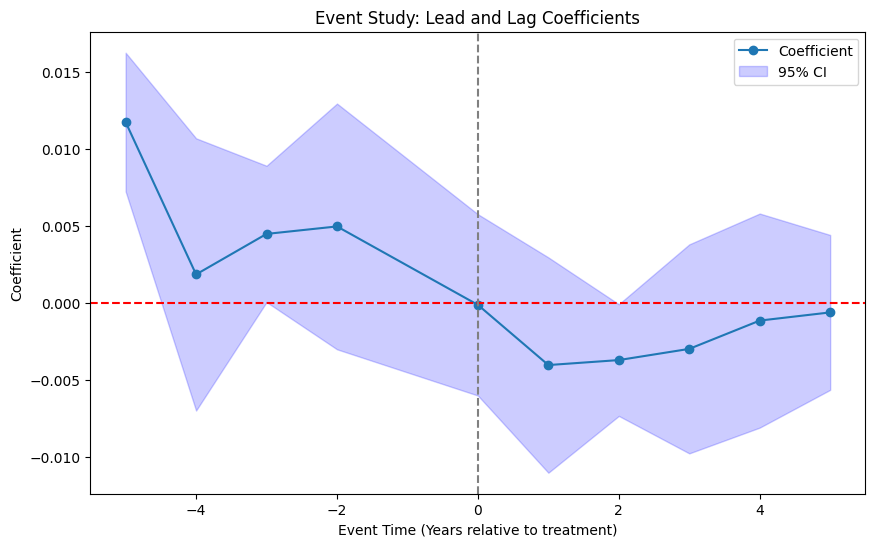

In [23]:
import matplotlib.pyplot as plt

# Extract event coefficients and std errors from your model summary
coef_table = model.summary2().tables[1]

# Select event terms (both leads and lags)
event_terms = [col for col in coef_table.index if col.startswith('event')]

# Extract coefficients and standard errors
coefs = coef_table.loc[event_terms, 'Coef.']
std_errs = coef_table.loc[event_terms, 'Std.Err.']

# Calculate 95% confidence intervals
ci_upper = coefs + 1.96 * std_errs
ci_lower = coefs - 1.96 * std_errs

# Convert event names to numeric x-axis values
def event_to_num(ev):
    if ev.startswith('event_m'):
        return -int(ev.split('_m')[1])
    else:
        return int(ev.split('_')[1])

x_vals = [event_to_num(ev) for ev in event_terms]

# Sort by x-axis for plotting
sorted_indices = sorted(range(len(x_vals)), key=lambda i: x_vals[i])
x_sorted = [x_vals[i] for i in sorted_indices]
coefs_sorted = [coefs[i] for i in sorted_indices]
ci_upper_sorted = [ci_upper[i] for i in sorted_indices]
ci_lower_sorted = [ci_lower[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(10,6))
plt.plot(x_sorted, coefs_sorted, marker='o', label='Coefficient')
plt.fill_between(x_sorted, ci_lower_sorted, ci_upper_sorted, color='blue', alpha=0.2, label='95% CI')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel('Event Time (Years relative to treatment)')
plt.ylabel('Coefficient')
plt.title('Event Study: Lead and Lag Coefficients')
plt.legend()
plt.show()


In [27]:
import pandas as pd
import statsmodels.formula.api as smf

# Ensure date columns are datetime
dataset['date_of_registration'] = pd.to_datetime(dataset['date_of_registration'])
dataset['date_of_removal'] = pd.to_datetime(dataset['date_of_removal'])

# Create monthly periods for registration and removal dates
dataset['registration_month'] = dataset['date_of_registration'].dt.to_period('M')
dataset['removal_month'] = dataset['date_of_removal'].dt.to_period('M')

# Define full monthly range (from min registration to max removal month)
min_month = dataset['registration_month'].min()
max_month = dataset['removal_month'].max()
all_months = pd.period_range(min_month, max_month, freq='M')

# Compute number of active charities at the end of each month by local authority
active_by_month_la = {}

for month in all_months:
    # Active means registered before or on month AND not removed before or on month
    active_mask = (
        (dataset['registration_month'] <= month) &
        (
            dataset['removal_month'].isna() |
            (dataset['removal_month'] > month)
        )
    )
    active_count = (
        dataset[active_mask]
        .groupby('local_authority')
        .size()
        .rename(str(month))
    )
    active_by_month_la[month] = active_count

active_by_month_la_df = pd.DataFrame(active_by_month_la).fillna(0).astype(int)

# Count removals by month and local authority
removed_by_month_la = (
    dataset
    .groupby(['local_authority', 'removal_month'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# Align indices of active and removal data
active_by_month_la_df = active_by_month_la_df.reindex(removed_by_month_la.index)

# Calculate removal rate per month
removal_rate_by_month_la = removed_by_month_la / active_by_month_la_df

# Convert wide to long format for panel data
panel_df = removal_rate_by_month_la.reset_index().melt(
    id_vars='local_authority',
    var_name='month',
    value_name='removed_rate'
)

# Convert 'month' back to Period type for date calculations
panel_df['month'] = panel_df['month'].astype(str).apply(pd.Period)

# Add treatment info
treatment_map = dataset.groupby('local_authority')[['treatment', 'treatment_date']].first()
panel_df = panel_df.merge(treatment_map, on='local_authority', how='left')

# Compute 'post' indicator at monthly granularity
panel_df['treatment_month'] = panel_df['treatment_date'].dt.to_period('M')
panel_df['post'] = (panel_df['month'] >= panel_df['treatment_month']).astype(int)
panel_df.loc[panel_df['treatment'].isna(), 'post'] = 0  # untreated always 0

# Convert month Period to string for fixed effects
panel_df['month_str'] = panel_df['month'].astype(str)

# Build formula with month fixed effects
formula = (
    'removed_rate ~ post + treatment + treatment:post + '
    'C(local_authority) ' 
)

# Fit model with clustered standard errors by local authority
model = smf.ols(formula, data=panel_df).fit()

summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           removed_rate   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9938
Date:                Thu, 03 Jul 2025   Prob (F-statistic):              0.522
Time:                        15:48:41   Log-Likelihood:             1.2816e+05
No. Observations:               44100   AIC:                        -2.556e+05
Df Residuals:                   43749   BIC:                        -2.526e+05
Df Model:                         350                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      0.0090      0.001      7.618      0.000       0.007       0.011
C(local_authority)[T.Aberdeenshire]                           -0.0077      0.002     -4.596      0.000      -0.011      -0.004
C(local_authority)[T.Adur]                                    -0.0069      0.002     -4.151      0.000      -0.010      -0.004
C(local_authority)[T.Amber Valley]                            -0.0069      0.002     -4.131      0.000      -0.010      -0.004
C(local_authority)[T.Angus]                                   -0.0070      0.002     -4.201      0.000      -0.010      -0.004
C(local_authority)[T.Argyll and Bute]                         -0.0064      0.002     -3.806      0.000      -0.010      -0.003
C(local_authority)[T.Armagh City, Banbridge and Craigavon]    -0.0064      0.002     -3.806      0.000      -0.010      -0.003
C(local_authority)[T.Arun]                                    -0.0065      0.002     -3.870      0.000      -0.010      -0.003
C(local_authority)[T.Ashfield]                                -0.0062      0.002     -3.681      0.000      -0.009      -0.003
C(local_authority)[T.Ashford]                                 -0.0069      0.002     -4.120      0.000      -0.010      -0.004
C(local_authority)[T.Babergh]                                 -0.0071      0.002     -4.246      0.000      -0.010      -0.004
C(local_authority)[T.Barking and Dagenham]                    -0.0069      0.002     -4.129      0.000      -0.010      -0.004
C(local_authority)[T.Barnet]                                  -0.0072      0.002     -4.325      0.000      -0.011      -0.004
C(local_authority)[T.Barnsley]                                -0.0064      0.002     -3.819      0.000      -0.010      -0.003
C(local_authority)[T.Basildon]                                -0.0068      0.002     -4.048      0.000      -0.010      -0.003
C(local_authority)[T.Basingstoke and Deane]                   -0.0067      0.002     -3.996      0.000      -0.010      -0.003
C(local_authority)[T.Bassetlaw]                               -0.0072      0.002     -4.298      0.000      -0.010      -0.004
C(local_authority)[T.Bath and North East Somerset]            -0.0071      0.002     -4.250      0.000      -0.010      -0.004
C(local_authority)[T.Bedford]                                 -0.0065      0.002     -3.876      0.000      -0.010      -0.003
C(local_authority)[T.Belfast]                                 -0.0062      0.002     -3.674      0.000      -0.009      -0.003
C(local_authority)[T.Bexley]                                  -0.0071      0.002     -4.254      0.000      -0.010      -0.004
C(local_authority)[T.Birmingham]   

DRAFT

In [11]:
# Step 1: Calculate total 2024 housing stock per council (Local authority only)
stock_2024 = (
    housing_stock_df
    .groupby(['Authority_code', 'Authority_name'], as_index=False)['LA_number']
    .sum()
    .rename(columns={'LA_number': 'Stock_2024'})
)

# Step 2: Prepare Net Supply Data
net = housing_net_supply_df.copy()
net = net[net['Year'].astype(str).str.match(r'^\d{4}/\d{2}$')]  # Keep only year-formatted rows
net['Year'] = net['Year'].str[:4].astype(int)  # Convert '2015/16' → 2015

# Pivot to Local Authority x Year format
net_pivot = net.pivot(index='LA_code', columns='Year', values='Net_additions').fillna(0)
net_pivot = net_pivot[sorted(net_pivot.columns, reverse=True)]  # descending order

# Step 3: Merge with 2024 stock
stock = stock_2024.set_index('Authority_code')
net_pivot = net_pivot.reindex(stock.index)  # align index

# Step 4: Calculate total stock backwards from 2024
stock_by_year = pd.DataFrame(index=net_pivot.index)
stock_by_year[2024] = stock['Stock_2024']

for year in sorted(net_pivot.columns, reverse=True):
    if year < 2024:
        stock_by_year[year] = stock_by_year[year + 1] - net_pivot[year]

# Step 5: Merge back Authority name and reshape
stock_by_year = stock_by_year.merge(stock[['Authority_name']], left_index=True, right_index=True)
stock_by_year_reset = stock_by_year.reset_index().melt(id_vars=['Authority_code', 'Authority_name'], 
                                                       var_name='Year', value_name='Housing stock')

# Final pivot
stock_by_year_pivot = stock_by_year_reset.pivot(index=['Authority_code', 'Authority_name'], 
                                                 columns='Year', values='Housing stock').sort_index(axis=1)

# Reset index, rename, and set it again
stock_by_year_pivot = stock_by_year_pivot.reset_index().rename(columns={'Authority_code': 'ONS code'})
stock_by_year_pivot = stock_by_year_pivot.set_index(['ONS code', 'Authority_name'])


NameError: name 'housing_stock_df' is not defined

In [ ]:
# Filter: Remove NaN and keep only rows where 'Year' matches 'YYYY/YY'
ladataset_filtered = ladataset[
    ladataset['Year'].notna() & ladataset['Year'].str.match(r'^\d{4}/\d{2}$')
]
ladataset_filtered['Year'] = ladataset_filtered['Year'].str[:4].astype(int)

# Pivot
ladataset_pivot = ladataset_filtered.pivot_table(
    index=['ONS code', 'Local authority', 'Measure'],
    columns='Year',
    values='£ millions, cash terms',
    aggfunc='sum'
).reset_index()

# Group by 'con_code' only
population_summary = (
    population
    .groupby('con_code', as_index=False)
    .agg({'con_name': 'first', 'con_number': 'sum'})
    .rename(columns={'con_name': 'Local authority', 'con_number': 'Total Population'})
)

# Display the result
print(population_summary.head())


In [ ]:
# Filter for Core Spending Power (CSP)
csp = ladataset_pivot.copy()

# Keep only relevant years
csp = csp.set_index(['ONS code', 'Local authority']).drop(columns='Measure')

# Calculate % change from 2015
csp['financial_distress'] = (csp[2024] - csp[2015]) / csp[2015]

fd = csp[['financial_distress']].reset_index()

fd.columns.name = None
housing_stock_processed = housing_stock_df[housing_stock_df['Tenure'] == 'Local authority'][['Authority_code', 'LA_number']]
fd_new = fd.merge(housing_stock_processed, left_on='ONS code', right_on='Authority_code', how='inner')
fd_new = fd_new.drop(columns='Authority_code')
fd_new = fd_new.rename(columns={'LA_number': 'LA Housing stock 2024'})


In [ ]:
# Step 1: Normalise both variables
fd_new['financial_distress_norm'] = (
    (fd_new['financial_distress'] - fd_new['financial_distress'].min()) /
    (fd_new['financial_distress'].max() - fd_new['financial_distress'].min())
)

fd_new['LA Housing stock 2024_norm'] = (
    (fd_new['LA Housing stock 2024'] - fd_new['LA Housing stock 2024'].min()) /
    (fd_new['LA Housing stock 2024'].max() - fd_new['LA Housing stock 2024'].min())
)

# Step 2: Avoid division by zero and calculate treatment
fd_new['treatment'] = np.where(
    fd_new['LA Housing stock 2024_norm'] != 0,
    fd_new['financial_distress_norm'] / fd_new['LA Housing stock 2024_norm'],
    0
)
fd_new.rename(columns={'Local authority': 'local_authority'}, inplace=True)

In [ ]:
# Step 2: Filter valid rows
removed = dataset[dataset['removal_fy'].notnull() & dataset['local_authority'].notnull()].copy()
removed['removal_fy'] = removed['removal_fy'].astype(int)

# Step 3: Group by financial year and local authority
removed_by_fy_la = (
    removed
    .groupby(['local_authority', 'removal_fy'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)

# Step 4: Keep only FY 2015–2024
fy_years = list(range(2015, 2025))
removed_by_fy_la = removed_by_fy_la[removed_by_fy_la.columns.intersection(fy_years)]

# Step 5: Total and sort
removed_by_fy_la['Total'] = removed_by_fy_la.sum(axis=1)
removed_by_fy_la = removed_by_fy_la.sort_values(by='Total', ascending=False)

# Step 6: Preview top 10
print("Removed Charities per Financial Year per Local Authority (FY 2015–2024):")
print(removed_by_fy_la.head(10))

In [ ]:
# Step 1: Define year range
years = list(range(2015, 2025))

# Step 2: Calculate percentage change across years
removed_pct_change = removed_by_fy_la[years].pct_change(axis=1) * 100

# Step 3: Round for readability
removed_pct_change = removed_pct_change.round(2)
removed_pct_change